0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
[[4.78390983e-04 1.61307197e-03 5.57921699e-03 2.26191330e-02
  9.34853520e-02 3.66123930e-01 1.70002231e+00 9.05196387e+00
  2.60809942e+01 9.10544500e+01]
 [5.17287001e-04 1.76974302e-03 5.06198200e-03 1.59421680e-02
  4.31502370e-02 1.36238607e-01 5.71722956e-01 1.58231480e+00
  3.74039746e+00 9.41283063e+00]
 [8.74860998e-04 3.41977700e-03 6.83609201e-03 1.45170930e-02
  5.98611770e-02 1.45263710e-01 4.98596369e-01 9.60528447e-01
  2.58202912e+00 6.41529391e+00]]


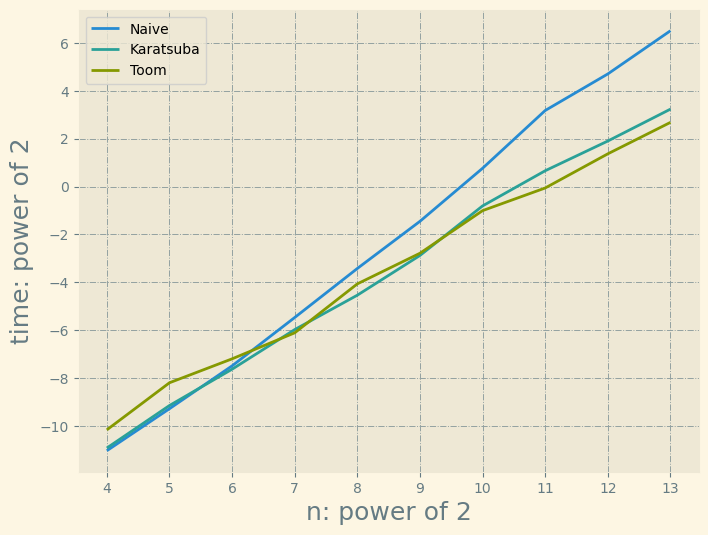

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import sys

sys.set_int_max_str_digits(100000)

np.random.seed(0)


def align(x, y, n_x, n_y):  # 若x和y长度不同 将短的左边补零
    if n_x < n_y:
        x = x.rjust(n_y, "0")
        n = n_y
    else:
        y = y.rjust(n_x, "0")
        n = n_x
    return x, y, n


def naive(x, y):
    n_x, n_y = len(x), len(y)
    x, y, n = align(x, y, n_x, n_y)
    c = 0  # 初始进位为零
    z = str()
    for k in range(2 * n):
        # 遍历所有满足i+j=k的二元组(i,j) i的遍历范围需注意防止越界
        for i in range(max(0, k - n + 1), min(k + 1, n)):
            j = k - i
            c += int(x[-1 - i]) * int(y[-1 - j])
        c, q = divmod(c, 10)
        z = str(q) + z
    z = z.lstrip("0")  # 去掉高位连续的0
    if z == "":  # 若乘积本就是0 去掉所有0后会变成空字符串
        return 0
    else:
        return int(z)


def karatsuba(x, y):
    n_x, n_y = len(x), len(y)

    if n_x == 1 or n_y == 1:  # 如果其中一个数只有1位 不再递归
        return int(x) * int(y)

    x, y, n = align(x, y, n_x, n_y)

    m = n // 2
    a, b = x[0:n - m], x[n - m:n]
    c, d = y[0:n - m], y[n - m:n]

    # 3个递归子问题
    ac = karatsuba(a, c)
    bd = karatsuba(b, d)
    ad_bc = karatsuba(str(int(a) + int(b)), str(int(c) + int(d))) - ac - bd

    return ac * 10**(2 * m) + ad_bc * 10**m + bd


def preprocess(x):
    if x[0] == "-":
        return -1, len(x) - 1, x[1:]
    return 1, len(x), x


def toom(x, y):
    sign_x, n_x, x = preprocess(x)
    sign_y, n_y, y = preprocess(y)
    sign = sign_x * sign_y

    if n_x <= 2 or n_y <= 2:  # 如果其中一个数小于3位 不再递归
        return sign * int(x) * int(y)

    x, y, n = align(x, y, n_x, n_y)

    m = int(np.around(n / 3))

    a, b, c = x[0:n - 2 * m], x[n - 2 * m:n - m], x[n - m:n]
    d, e, f = y[0:n - 2 * m], y[n - 2 * m:n - m], y[n - m:n]

    # 5个递归子问题
    s4 = toom(a, d)  # s4 = ad
    s3 = toom(str(4 * int(a) + 2 * int(b) + int(c)), str(4 * int(d) + 2 * int(e) + int(f)))  # s3 = (4a+2b+c)(4d+2e+f)
    s2 = toom(str(int(a) - int(b) + int(c)), str(int(d) - int(e) + int(f)))  # s2 = (a-b+c)(d-e+f)
    s1 = toom(str(int(a) + int(b) + int(c)), str(int(d) + int(e) + int(f)))  # s1 = (a+b+c)(d+e+f)
    s0 = toom(c, f)  # s0 = cf

    w4 = s4
    w3 = (-12 * s4 + s3 - s2 - 3 * s1 + 3 * s0) // 6
    w2 = (-2 * s4 + s2 + s1 - 2 * s0) // 2
    w1 = (12 * s4 - s3 - 2 * s2 + 6 * s1 - 3 * s0) // 6
    w0 = s0

    return sign * (w4 * 10**(4 * m) + w3 * 10**(3 * m) + w2 * 10**(2 * m) + w1 * 10**m + w0)


trial = 10
time_cost = np.empty((3, trial))
for t in range(trial):
    n = 2**(t + 4)  # 2^4, 2^5, ..., 2^13

    # 随机生成长度为n的字符串x和y
    x, y = ''.join(random.choices(string.digits, k=n)), ''.join(random.choices(string.digits, k=n))

    start = time.perf_counter()
    z0 = naive(x, y)
    time_cost[0, t] = time.perf_counter() - start

    start = time.perf_counter()
    z1 = karatsuba(x, y)
    time_cost[1, t] = time.perf_counter() - start

    start = time.perf_counter()
    z2 = toom(x, y)
    time_cost[2, t] = time.perf_counter() - start

    print(z0 - z1, z0 - z2)

print(time_cost)

with plt.style.context('Solarize_Light2'):
    _, ax = plt.subplots(figsize=(8, 6))
    x = [v + 4 for v in range(trial)]
    ax.plot(x, np.log2(time_cost[0, :]), label="Naive")  # 对数坐标轴
    ax.plot(x, np.log2(time_cost[1, :]), label="Karatsuba")
    ax.plot(x, np.log2(time_cost[2, :]), label="Toom")
    ax.set_xlabel("n: power of 2", fontsize=18)
    ax.set_ylabel("time: power of 2", fontsize=18)
    ax.legend(loc="best")
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(2))
    ax.grid(color='#93a1a1', linestyle='-.', linewidth=0.7)
    plt.show()

In [1]:
a = round(3.5)
print(a)
print(type(a))

4
<class 'int'>
